## A Python data structure to improve handling of datasets in machine learning workflows

This class is greatly suited for neuroimaging applications (or any other domain), where each sample needs to be uniquely identified with a subject ID (or something similar). 

Key-level correspondence across data, labels (1 or 2), classnames ('healthy', 'disease') and the related helps maintain data integrity and improve the provenance, in addition to enabling traceback to original sources from where the features have been originally derived.

An example application is shown below, touching upon the following topics:

* <a href='#constructor'>Constructor</a>

* <a href='#attributes'>Attributes</a>

* <a href='#iteration'>Iteration over samples</a>

* <a href='#subsetselection'>Subset selection</a>

* <a href='#serialization'>Serialization</a>

* <a href='#arithmetic'>Arithmetic</a>

* <a href='#portability'>Portability (e.g. with sklearn)</a>


Improting the necessary modules and our fancy class definition:

In [93]:
import sys, os
import numpy as np
from mldataset import MLDataset

We can now instantiate it and give it a description:

In [94]:
dataset = MLDataset()
dataset.description = 'ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.'

In [95]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
Empty dataset.

You can see the dataset some description attached to it, however we know it is empty. This can be verified in a boolean context as shown below:

In [96]:
bool(dataset)

False

Let's add samples to this dataset which is when this dataset implementation becomes really handy. Before we do that, we will define some convenience routines defined to just illustrate a simple yet common use of this dataset.

In [97]:
def read_thickness(path):
    """Dummy function to minic a data reader."""

    # in your actural routine, this might be:
    #   pysurfer.read_thickness(path).values()
    return np.random.random(2)


def get_features(work_dir, subj_id):
    """Returns the whole brain cortical thickness for a given subject ID."""

    # extension to identify the data file; this could be .curv, anything else you choose
    ext_thickness = '.thickness'

    thickness = dict()
    for hemi in ['lh', 'rh']:
        path_thickness = os.path.join(work_dir, subj_id, hemi + ext_thickness)
        thickness[hemi] = read_thickness(path_thickness)

    # concatenating them to build a whole brain feature set
    thickness_wb = np.concatenate([thickness['lh'], thickness['rh']])

    return thickness_wb

So now we have IO routines to read the data for us. Let's define where the data will come from:

In [98]:
work_dir = '/project/ADNI/FreesurferThickness_v4p3'
class_set = ['Ctrl', 'Alzr', 'Another']

This would obviously change for your applications, but this has sufficient properties to illustrate the point.

Let's look at what methods this dataset offers us:

In [99]:
dir(dataset)

['add_classes',
 'add_sample',
 'class_set',
 'class_sizes',
 'classes',
 'data',
 'data_matrix',
 'del_sample',
 'description',
 'extend',
 'get_class',
 'get_feature_subset',
 'get_subset',
 'glance',
 'keys',
 'num_classes',
 'num_features',
 'num_samples',
 'sample_ids',
 'save',
 'target']

<a id='constructor'></a>

## Constructor

You can see there few methods such as add_sample, get_subset etc: important method being add_sample, which is key to constructing this dataset. Let's go ahead and some samples:

In [100]:
for class_index, class_id in enumerate(class_set):
    print('Working on class {:>5}'.format(class_id))

    target_list_path = os.path.join(work_dir,'scripts','test_sample.{}'.format(class_id))
    with open(target_list_path,'r') as tf:
        target_list = tf.readlines()
        target_list = [sub.strip() for sub in target_list]

    for subj_id in target_list:
        print('\t reading subject {:>15}'.format(subj_id))
        thickness_wb = get_features(work_dir, subj_id)

        # adding the sample to the dataset
        dataset.add_sample(subj_id, thickness_wb, class_index, class_id)

Working on class  Ctrl
	 reading subject      011_S_0005
	 reading subject      011_S_0008
	 reading subject      022_S_0014
	 reading subject      100_S_0015
	 reading subject      011_S_0016
	 reading subject      067_S_0019
	 reading subject      011_S_0021
	 reading subject      011_S_0022
	 reading subject      011_S_0023
	 reading subject      023_S_0031
Working on class  Alzr
	 reading subject      031_S_1209
	 reading subject      007_S_1248
	 reading subject      007_S_1304
	 reading subject      009_S_1334
	 reading subject      007_S_1339
	 reading subject      005_S_1341
	 reading subject      057_S_1371
	 reading subject      057_S_1379
	 reading subject      041_S_1391
	 reading subject      094_S_1402
Working on class Another
	 reading subject      130_S_1200
	 reading subject      130_S_1201
	 reading subject      130_S_1290
	 reading subject      130_S_1337
	 reading subject      131_S_0123
	 reading subject      131_S_0319
	 reading subject      131_S_0384
	 reading s

**Nice. Isn't it?**

So what's nice about this, you say? *The simple fact that you are constructing a dataset as you read the data* in its most elemental form (in the units of the dataset such as the subject ID in our neuroimaging application). You're done as soon as you're done reading the features from disk.

What's more - you can inspect the dataset in an intuitive manner, as shown below:

In [101]:
dataset

ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
30 samples and 4 features.
Class    Alzr : 10 samples.
Class Another : 10 samples.
Class    Ctrl : 10 samples.

Even better, right? No more too much typing of several commands to get the complete and concise sense of the dataset.

<a id='attributes'></a>

## Convenient attributes

If you would like, you can always get more specific information, such as:

In [102]:
dataset.num_samples

30

In [103]:
dataset.num_features

4

In [104]:
dataset.class_set

{'Alzr', 'Another', 'Ctrl'}

In [105]:
dataset.class_sizes

Counter({'Alzr': 10, 'Another': 10, 'Ctrl': 10})

In [106]:
dataset.class_sizes['Ctrl']

10

If you'd like to take a look data inside for few subjects - shall we call it a glance?

In [107]:
dataset.glance()

{'011_S_0005': array([ 0.06,  0.04,  0.37,  0.52]),
 '011_S_0008': array([ 0.39,  0.25,  0.48,  0.55]),
 '011_S_0016': array([ 0.35,  0.58,  0.21,  0.81]),
 '022_S_0014': array([ 0.14,  0.19,  0.71,  0.32]),
 '100_S_0015': array([ 0.09,  0.84,  0.55,  0.73])}

We can control the number of items to glance, by passing a number to dataset.glance() method:

In [108]:
np.set_printoptions(precision=2) # save some screen space
dataset.glance(2)

{'011_S_0005': array([ 0.06,  0.04,  0.37,  0.52]),
 '011_S_0008': array([ 0.39,  0.25,  0.48,  0.55])}

Or you may be wondering what are the subject IDs in the dataset.. here they are:

In [109]:
dataset.sample_ids

['011_S_0005',
 '011_S_0008',
 '022_S_0014',
 '100_S_0015',
 '011_S_0016',
 '067_S_0019',
 '011_S_0021',
 '011_S_0022',
 '011_S_0023',
 '023_S_0031',
 '031_S_1209',
 '007_S_1248',
 '007_S_1304',
 '009_S_1334',
 '007_S_1339',
 '005_S_1341',
 '057_S_1371',
 '057_S_1379',
 '041_S_1391',
 '094_S_1402',
 '130_S_1200',
 '130_S_1201',
 '130_S_1290',
 '130_S_1337',
 '131_S_0123',
 '131_S_0319',
 '131_S_0384',
 '131_S_0409',
 '131_S_0436',
 '131_S_0441']

<a id='iteration'></a>

## Iteration over samples

Thanks to its dictionary based implementation, data for a given sample '007_S_1248' can simply be obtained by:

In [110]:
dataset.data['007_S_1248']

array([ 0.1 ,  0.21,  0.89,  0.22])

we can easily iterate over all the samples to obtain their data as well as class labels. Let's see it in action:

In [111]:
for sample, features in dataset.data.items():
    print "{} : {:>10} : {}".format(sample, dataset.classes[sample], features)

011_S_0005 :       Ctrl : [ 0.06  0.04  0.37  0.52]
011_S_0008 :       Ctrl : [ 0.39  0.25  0.48  0.55]
022_S_0014 :       Ctrl : [ 0.14  0.19  0.71  0.32]
100_S_0015 :       Ctrl : [ 0.09  0.84  0.55  0.73]
011_S_0016 :       Ctrl : [ 0.35  0.58  0.21  0.81]
067_S_0019 :       Ctrl : [ 0.41  0.53  0.08  0.35]
011_S_0021 :       Ctrl : [ 0.93  0.74  0.18  0.67]
011_S_0022 :       Ctrl : [ 0.75  0.74  0.61  0.12]
011_S_0023 :       Ctrl : [ 0.45  0.93  0.73  0.55]
023_S_0031 :       Ctrl : [ 0.79  0.63  0.17  0.33]
031_S_1209 :       Alzr : [ 0.18  0.34  0.65  0.71]
007_S_1248 :       Alzr : [ 0.1   0.21  0.89  0.22]
007_S_1304 :       Alzr : [ 0.17  0.72  0.66  0.34]
009_S_1334 :       Alzr : [ 0.55  0.98  0.72  0.03]
007_S_1339 :       Alzr : [ 0.77  0.98  0.34  0.11]
005_S_1341 :       Alzr : [ 0.54  0.55  0.57  0.47]
057_S_1371 :       Alzr : [ 0.09  0.78  0.71  0.24]
057_S_1379 :       Alzr : [ 0.86  0.78  0.4   0.17]
041_S_1391 :       Alzr : [ 0.17  0.93  0.94  0.21]
094_S_1402 :

Thanks to the choice of the OrderedDict() for each of the data, classes and labels, the order of sample addition is retained. Hence the correspondence across samples in the dataset not only key-wise (by the sample id), but also index-wise.

Another example to illustrate how one can access the subset of features e.g. cortical thickness for a particular region of interest (say posterior cingulate gyrus) is below:

In [112]:
# let's make a function to return the indices for the ROI
def get_ROI_indices(ctx_label=None):
    if ctx_label == 'post_cingulate_gyrus':
        return xrange(2) # dummy for now
    else:
        return xrange(dataset.num_features) # all the features

Now the following code iterates over each sample and prints the average cortical thickness in the specific ROI:

In [113]:
avg_thickness = dict()
for sample, features in dataset.data.items():
    avg_thickness[sample] = np.mean(features[get_ROI_indices('post_cingulate_gyrus')])
    print "{} {:>10}  {:.2f}".format(sample, dataset.classes[sample], avg_thickness[sample] )

011_S_0005       Ctrl  0.05
011_S_0008       Ctrl  0.32
022_S_0014       Ctrl  0.16
100_S_0015       Ctrl  0.47
011_S_0016       Ctrl  0.47
067_S_0019       Ctrl  0.47
011_S_0021       Ctrl  0.84
011_S_0022       Ctrl  0.74
011_S_0023       Ctrl  0.69
023_S_0031       Ctrl  0.71
031_S_1209       Alzr  0.26
007_S_1248       Alzr  0.16
007_S_1304       Alzr  0.44
009_S_1334       Alzr  0.77
007_S_1339       Alzr  0.87
005_S_1341       Alzr  0.55
057_S_1371       Alzr  0.43
057_S_1379       Alzr  0.82
041_S_1391       Alzr  0.55
094_S_1402       Alzr  0.36
130_S_1200    Another  0.64
130_S_1201    Another  0.72
130_S_1290    Another  0.47
130_S_1337    Another  0.64
131_S_0123    Another  0.57
131_S_0319    Another  0.37
131_S_0384    Another  0.69
131_S_0409    Another  0.54
131_S_0436    Another  0.15
131_S_0441    Another  0.29


Let's make a bar plot with the just computed numbers:

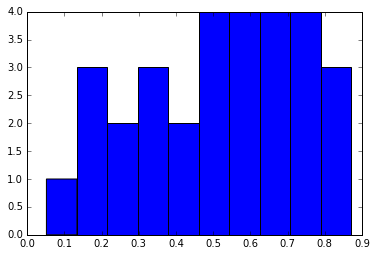

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline
n, bins, patches = plt.hist(avg_thickness.values())

Remember as the original source of data was random, this has no units, property or meaning!

<a id='subsetselection'></a>

## Subset selection

In addition to the structured way of obtaining the various properties of this dataset, this implementation really will come in handy when you have to slice and dice the dataset (with large number of classes and features) into smaller subsets (e.g. for binary classification). Let's see how we can retrieve the data for a single class:

In [115]:
ctrl = dataset.get_class('Ctrl')

That's it, obtaining the data for a given class is a simple call away.

Now let's see what it looks like:

In [116]:
ctrl


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
10 samples and 4 features.
Class Ctrl : 10 samples.

Even with updated description automatically, to indicate its history. Let's see some data from controls:

In [117]:
ctrl.glance(2)

{'011_S_0005': array([ 0.06,  0.04,  0.37,  0.52]),
 '011_S_0008': array([ 0.39,  0.25,  0.48,  0.55])}

#### Let's see how we can retrieve specific samples by their IDs (for which there are many use cases):

In [118]:
data = dataset.get_subset(['022_S_0014','023_S_0031','023_S_0031','131_S_0409'])

So as simple as that.

In [119]:
data


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
3 samples and 4 features.
Class Another : 1 samples.
Class    Ctrl : 2 samples.

#### More useful case would be to select a subset of classes from an original large dataset:

In [120]:
binary_dataset = dataset.get_class(['Ctrl','Alzr'])

In [121]:
binary_dataset


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
20 samples and 4 features.
Class Alzr : 10 samples.
Class Ctrl : 10 samples.

How about selecting a subset of features from all samples?

In [122]:
binary_dataset.get_feature_subset(xrange(2))

Subset features derived from: 
 
 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
20 samples and 2 features.
Class Alzr : 10 samples.
Class Ctrl : 10 samples.

**Great.** Isn't it? You can also see the two-time-point history (initial subset in classes, followed by a subset in features).

<a id='serialization'></a>

## Serialization

Once you have this dataset, you can save and load these trivially using your favourite serialization module. Let's do some pickling:

In [123]:
out_file = os.path.join(work_dir,'binary_dataset_Ctrl_Alzr_Freesurfer_thickness_v4p3.pkl')
binary_dataset.save(out_file)

That's it - it is saved.

Let's reload it from disk and make sure we can indeed retrieve it:

In [124]:
reloaded = MLDataset(filepath=out_file) # another form of the constructor!

Loading the dataset from: /project/ADNI/FreesurferThickness_v4p3/binary_dataset_Ctrl_Alzr_Freesurfer_thickness_v4p3.pkl


In [125]:
reloaded


 Subset derived from: ADNI1 baseline: cortical thickness features from Freesurfer v4.3, QCed.
20 samples and 4 features.
Class Alzr : 10 samples.
Class Ctrl : 10 samples.

<a id='arithmetic'></a>

## Dataset Arithmetic

You might wonder how can you combine two different types of features ( thickness and shape ) from the dataset. Piece of cake, see below ...

To concatenat two datasets, first we make a second dataset:

In [126]:
dataset_two = MLDataset(in_dataset=dataset) # yet another constructor: in its copy form!

How can you check if they are "functionally identical"? As in same keys, same data and classes for each key... Easy:

In [127]:
dataset_two == dataset

True

Now let's try the arithmentic:

In [128]:
combined = dataset + dataset_two

Identical keys found. Trying to horizontally concatenate features for each sample.


Great. The add method recognized the identical set of keys and performed a horiz cat, as can be noticed by the twice the number of features in the combined dataset:

In [129]:
combined


30 samples and 8 features.
Class    Alzr : 10 samples.
Class Another : 10 samples.
Class    Ctrl : 10 samples.

We can also do some removal in similar fashion:

In [130]:
smaller = combined - dataset

011_S_0005 removed.
011_S_0008 removed.
022_S_0014 removed.
100_S_0015 removed.
011_S_0016 removed.
067_S_0019 removed.
011_S_0021 removed.
011_S_0022 removed.
011_S_0023 removed.
023_S_0031 removed.
031_S_1209 removed.
007_S_1248 removed.
007_S_1304 removed.
009_S_1334 removed.
007_S_1339 removed.
005_S_1341 removed.
057_S_1371 removed.
057_S_1379 removed.
041_S_1391 removed.
094_S_1402 removed.
130_S_1200 removed.
130_S_1201 removed.
130_S_1290 removed.
130_S_1337 removed.
131_S_0123 removed.
131_S_0319 removed.
131_S_0384 removed.
131_S_0409 removed.
131_S_0436 removed.
131_S_0441 removed.


Data structure is even producing a warning to let you know the resulting output would be empty! We can verify that:

In [131]:
bool(smaller)

False

<a id='portability'></a>

## Portability

This is all well and good. How does it interact with other packages out there, you might ask? It is as simple as you can imagine:

In [132]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

In [133]:
clf.fit(binary_dataset.data_matrix, binary_dataset.target)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

There you have it, a simple example to show you the utility and convenience of this dataset.

### Thanks for checking it out. 

### I would appreciate if you could give me feedback on improving or sharpening it further.